In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

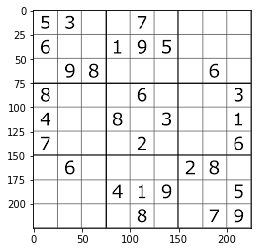

In [2]:
img = cv2.imread(r"C:\Users\vamshi krishna\Desktop\su_img.png", 0)
plt.imshow(img, 'gray')

# Applying Binary Threshold for finding sudoku boundaries


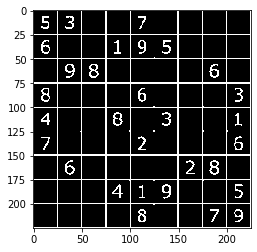

In [3]:
ret, thresh = cv2.threshold(img.copy(), 180, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, 'gray')

In [4]:
contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

We need to find the countour corresponding to puzzle boundary

In [5]:
cnts = sorted(contours, key=cv2.contourArea, reverse=True)
rect = None

for c in cnts:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02*perimeter, True)
    if len(approx)==4:
        rect = approx
        break

In [6]:
rect

array([[[  0,   0]],

       [[  0, 224]],

       [[224, 224]],

       [[224,   0]]], dtype=int32)


# Ordering the points of above Contour ie, Converting image to sudoku top down view

East direction is taken as positive X-axis and South direction is taken as positive Y-axis.
Top left point will have minimum sum and bottom right point will have maximum sum.
Top right will have smallest difference and Bottom left will have maximum difference.
rect stores points in order: top left, top right, bottom right, bottom left.

In [7]:
def orderpoints(pts):
    rect = np.zeros((4, 2), dtype="float32")
    # d stores sum of all four coordinates
    s = []
    for row in pts:
        s.append(np.sum(row, axis=1))
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    
    # d stores difference of all four coordinates
    d = []
    for row in pts:
        d.append(np.diff(row, axis=1))
    tr = pts[np.argmin(d)]
    bl = pts[np.argmax(d)]
    
    # Store tl, tr, br, bl in rect
    rect[0]=tl
    rect[1]=tr
    rect[2]=br
    rect[3]=bl
    
    return rect

# Croping image of sudoku

In [8]:
def four_point_transform(image, pts):
    rect = orderpoints(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))  
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    #refer geeks for geeks for perspective transform
    
    matrix = cv2.getPerspectiveTransform(rect, dst)
    wrapped = cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))
    
    return wrapped

Preproceesing of image is done 

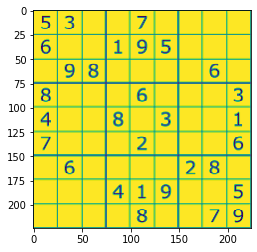

In [9]:
img_preprocessed = four_point_transform(img, rect)
plt.imshow(img_preprocessed)

Here we get almost same image as input image but when we have some other objects in the image along with sudoku then we can see the difference

# Digits Recognisation using CNN 

In [10]:
from keras.datasets import mnist

Using TensorFlow backend.


In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

from keras.layers.normalization import BatchNormalization

from keras.utils import np_utils

In [12]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [13]:
X_train.shape

(60000, 28, 28)

In [14]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [15]:
X_train = X_train/255
X_test = X_test/255

In [16]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [17]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(512,activation="relu"))    
model.add(Dense(10,activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 569s 9ms/step - loss: 0.0981 - accuracy: 0.9713 - val_loss: 0.0421 - val_accuracy: 0.9877
Epoch 2/5
60000/60000 [==============================] - 728s 12ms/step - loss: 0.0491 - accuracy: 0.9856 - val_loss: 0.0240 - val_accuracy: 0.9921
Epoch 3/5
60000/60000 [==============================] - 746s 12ms/step - loss: 0.0378 - accuracy: 0.9888 - val_loss: 0.0310 - val_accuracy: 0.9897
Epoch 4/5
60000/60000 [==============================] - 1108s 18ms/step - loss: 0.0308 - accuracy: 0.9905 - val_loss: 0.0589 - val_accuracy: 0.9857
Epoch 5/5
60000/60000 [==============================] - 1504s 25ms/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0334 - val_accuracy: 0.9906


In [198]:
y_pred = model.predict(X_test)

In [29]:
y_test[98]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [30]:
np.argmax(y_pred[98], axis=0)

6

In [31]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 29s 3ms/step


[0.033386423725724854, 0.9905999898910522]

In [199]:
test = cv2.imread(r"C:\Users\vamshi krishna\Desktop\w3.jpg", 0)

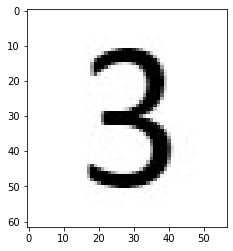

In [200]:
plt.imshow(test, 'gray')

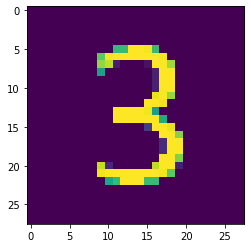

In [201]:
ret, thresh = cv2.threshold(test.copy(), 100, 255, cv2.THRESH_BINARY_INV)
resized_digit = cv2.resize(thresh, (28, 28))
plt.imshow(resized_digit)
resized_digit = resized_digit.reshape(1, 28, 28, 1)

In [94]:
X_test[[0]].shape

(1, 28, 28, 1)

In [95]:
resized_digit.shape

(1, 28, 28, 1)

In [202]:
predicted = model.predict(resized_digit)

In [203]:
np.argmax(predicted, axis=1)

array([3], dtype=int64)

In [204]:
predicted

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [209]:
def predict(img):
    predicted_image = model.predict(img)
    digit = np.argmax(predicted_image, axis=1)
    
    if digit==[0]:
        return 0
    if digit==[1]:
        return 1
    if digit==[2]:
        return 2
    if digit==[3]:
        return 3
    if digit==[4]:
        return 4
    if digit==[5]:
        return 5
    if digit==[6]:
        return 6
    if digit==[7]:
        return 7
    if digit==[8]:
        return 8
    if digit==[9]:
        return 9

In [210]:
predict(resized_digit)

3

# Finding cells and extracting digits into a matrix

In [211]:
def getCellPositions(img_PT):
    img_PT = cv2.resize(img,(252,252))
    
    cell_positions = []
    
    width = img_PT.shape[1]
    height = img_PT.shape[0]
    
    cell_width = width//9
    cell_height = height//9
    
    x1,x2,y1,y2 = 0,0,0,0
    
    for i in range(9):
        y2 = y1 + cell_height
        x1 = 0
        for j in range(9):
            x2 = x1 + cell_width
            current_cell = [x1,x2,y1,y2]
            cell_positions.append(current_cell)
            x1 = x2
        y1 = y2
    return cell_positions  

In [212]:
def predictDigit(cell,img):
    pos = []
    img = cv2.resize(img,(252,252))
    img = img[cell[2]+2:cell[3]-3,cell[0]+2:cell[1]-3]
    contours,hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:

        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            # if the contour is sufficiently large, it must be a digit
            if (w < 15 and x > 2) and (h < 25 and y > 2):#multiplied each number by 9 due to the resized image
                #pos = (x,y,x+w,y+h)
                pos.append((x,y,x+w,y+h))
                break
    if pos == []:
        result = 0
    if pos:
        img1 = img[(pos[0][1]):(pos[0][3]),(pos[0][0]):(pos[0][2])]
        img1 = cv2.resize(img,(28,28))
        img1 = img1.reshape(1,28,28,1)
        result = predict(img1)
        
    return result

In [216]:
ret, threshfinal = cv2.threshold(img.copy(), 180, 255, cv2.THRESH_BINARY_INV)
final_img = four_point_transform(threshfinal, rect)

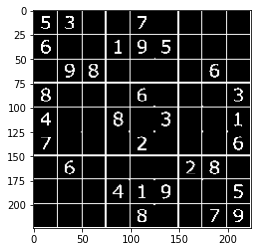

In [217]:
plt.imshow(final_img, 'gray')

# Lets Solve Sudoku :)

In [218]:
def extractSudokuDigits(img_PT):
    
    cell_digits,num = [],0
    cells = getCellPositions(img_PT)
    for cell in range(len(cells)):
        num = predictDigit(cells[cell],img_PT)
        cell_digits.append(num)
    n = 9
    cell_digits = [cell_digits[i:i+n] for i in range(0, len(cell_digits), n)] 
    return cell_digits

In [219]:
a = extractSudokuDigits(final_img)

In [243]:
a

[[5, 3, 0, 0, 7, 0, 0, 0, 0],
 [6, 0, 0, 1, 9, 5, 0, 0, 0],
 [0, 9, 8, 0, 0, 0, 0, 6, 0],
 [8, 0, 0, 0, 6, 0, 0, 0, 3],
 [4, 0, 0, 8, 0, 3, 0, 0, 1],
 [7, 0, 0, 0, 2, 0, 0, 0, 6],
 [0, 6, 0, 0, 0, 0, 2, 8, 0],
 [0, 0, 0, 4, 1, 9, 0, 0, 5],
 [0, 0, 0, 0, 8, 0, 0, 7, 9]]

# Solving sudoku with Backtracking 

In [244]:
#Finding Empty Cells
def find_empty(a):
    for i in range(len(a)):
        for j in range(len(a[0])):
            if a[i][j] == 0:
                return (i, j)
    return None

In [245]:
def valid(bo, num, pos):
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    for j in range(len(bo)):
        if bo[j][pos[1]] == num and pos[0] != j:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

In [246]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False

In [247]:
solve(a)

True

In [248]:
def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")

        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")

            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

In [249]:
print_board(a)

5 3 4  | 6 7 8  | 9 1 2
6 7 2  | 1 9 5  | 3 4 8
1 9 8  | 3 4 2  | 5 6 7
- - - - - - - - - - - - - 
8 5 9  | 7 6 1  | 4 2 3
4 2 6  | 8 5 3  | 7 9 1
7 1 3  | 9 2 4  | 8 5 6
- - - - - - - - - - - - - 
9 6 1  | 5 3 7  | 2 8 4
2 8 7  | 4 1 9  | 6 3 5
3 4 5  | 2 8 6  | 1 7 9


# Done :)